In [1]:
import numpy as np  # probably don't need to load
import pandas as pd
import datetime as dt
#import pandas_datareader.data as web  # probably don't need to load
#import quandl

#import blpapi
#from xbbg import blp

#import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [3]:
path = 'Z:/Shared/Risk Management and Investment Technology/CLO Optimization/'
file = 'CLO17 portfolio as of 04.15.21.xlsm'
filepath= path+file
CLO_tab = 'CLO 17 Port as of 4.15'
Bid_tab = 'Bid.Ask 4.15'


# Functions

## Key Stat Functions

### Constraints/Tests

- [x] WARF test
- [x] diversity test
- [ ] Over-Collateralization test 
- [x] par burn/build
- [ ] Interest Coverage Ratio: Ratio of total interest income generated by the underlying pool of assets to the total interest due on the debt (tranches) outstanding.
- [ ] weighted average life test - S&P Weighted Average Life”: On any date of determination, a number calculated 
    by determining the number of years between the current date and the maturity date of each USActive 55321025.6 S-8-3 
    Collateral Obligation (with an S&P Rating of “CCC-” or higher), multiplying each Collateral 
    Obligation’s principal balance by its number of years, summing the results of all Collateral 
    Obligations in the portfolio, and dividing such amount by the aggregate principal balance of all 
    Collateral Obligations (with an S&P Rating of “CCC-” or higher). 
- [x] recovery rate test
- [x] CCC percentage

- security level attributes

- [x] spread
- [x] (WA)rf
- [x] market price / purchase if own it
- [x] maturity
- [x] rating


- [x] calculate the marginal diversity


In [12]:
# this works; spot checked
def moodys_adjusted_warf(df,moodys_score,moodys_rfTable):
    """
    This function creates the new Moody's Ratings Factor based 
    on the old Moody's rating.
    
    Arg in:
        df: the input data frame (from the MASTER table d/l'd from BMS)
        moodys_score: dataframe with alphanumeric rating to numeric map (1 to 1 map; linear)
        moodys_rfTable: dataframe with alphanumeric rating to new WARF numeric (1 to 1 map; 1 to 1000 values)
    """
    score = df['Moodys CFR'].map(dict(moodys_score[['Moodys','Score']].values))
    updown = df['Moodys Issuer Watch'].\
        apply(lambda x: -1 if x == 'Possible Upgrade' else 1 if x == 'Possible Downgrade' else 0)
    aScore = score + updown
    Adjusted_CFR_for_WARF = aScore.map(dict(moodys_score[['Score','Moodys']].values))
    # I keep the same column name as Jeff to make it easier to double check values
    df['Adj. WARF NEW'] = Adjusted_CFR_for_WARF.map(dict(moodys_rfTable[['Moody\'s Rating Factor Table','Unnamed: 10']].values))
    return df

def sp_recovery_rate(model_df,lien,new_rr,bond_table):
    """
    This function get the S&P recovery rate as a percent. If it doesn't exist
    in the master field, it will look up in the appropriate first and second 
    lien tables, if not, will look up the bond table.
    
    Arg in:
        model_df: the input data frame (from the MASTER table d/l'd from BMS)
        lien: a DF table with the RR's for first and second lien by country
        new_rr: a df mapping of the old notation for RR to a new RR in percentage
        bond_table: split out of a table for RR for bonds
    Arg out:
        model_df with inserted new column 'S&P Recovery Rate (AAA)'
    """
     
    # if it the Recovery rate exists lookup in AAA table
    model_df['S&P Recovery Rate (AAA)'] = model_df['S&P Recovery'].\
        map(dict(new_rr[['S&P Recovery Rating\nand Recovery\nIndicator of\nCollateral Obligations','“AAA”']].values))
    
    # doesn't exist, but first lien, use first lien table
    model_df.loc[pd.isna(model_df['S&P Recovery']) & (model_df['Lien Type']== 'First Lien'),'S&P Recovery Rate (AAA)'] =\
        model_df.loc[pd.isna(model_df['S&P Recovery']) & (model_df['Lien Type']== 'First Lien'),'Issuer Country'].\
        map(dict(lien[['Country Abv','RR']].values))
    
    
    # doesn't exist, but 2nd lien, use 2nd lien table
    model_df.loc[pd.isna(model_df['S&P Recovery']) & (model_df['Lien Type']== 'Second Lien'),'S&P Recovery Rate (AAA)'] = \
        model_df.loc[pd.isna(model_df['S&P Recovery']) & (model_df['Lien Type']== 'Second Lien'),'Issuer Country'].\
        map(dict(lien[['Country Abv','RR.2nd']].values))
    
    # the bonds
    model_df.loc[pd.isna(model_df['S&P Recovery']) & pd.isna(model_df['Lien Type']),'S&P Recovery Rate (AAA)'] = \
        model_df.loc[pd.isna(model_df['S&P Recovery']) & pd.isna(model_df['Lien Type']),'Issuer Country'].\
        map(dict(bond_table[['Country Abv.1','RR.1']].values))

    return model_df

def diversity_score(model_df, ind_avg_eu, weight_col='Par_no_default'):
    """
    This function calculates the Moody's Industry Diversity Score for the CLO
    
    Arg in:
        model_df: the input data frame (from the MASTER table d/l'd from BMS)
        ind_avg_eu: Moody's discrete lookup table that maps AIEUS to IDS, need to be sorted
    Arg out:
        dscore: the scalar measure of the IDS
    """
    
    #first create the Par amount filtering out defaults
    #model_df['Par_no_default'] = model_df['Total']
    #model_df.loc[model_df['Default']=='Y','Par_no_default'] = 0
    div_df = model_df[['Parent Company','Moodys Industry',weight_col]].copy()
    div_df.sort_values(by='Moodys Industry',inplace=True)

    # this keeps the industry, but groups on parent company for multiple loans
    test = div_df.groupby(by=['Parent Company','Moodys Industry']).sum()
    avg_par_amt = test.sum()/test.count()   
    
    # create the EU score for each parent
    # Lesser of 1 and Issuer Par Amount for such issuer divided by the Average Par Amount.
    test['EU'] = test[[weight_col]]/test[[weight_col]].mean()
    test.loc[test['EU']>1,'EU']=1
    
    # groupby Industry for the Ind Div Score
    IDS = test.groupby(by=['Moodys Industry']).sum()

    # this is like vlookup(..,TRUE) where the nearest match on merge is used, direction controls how
    # backward is the lesser if EU falls between AIEUS marks
    df_merged = pd.merge_asof(IDS.sort_values('EU'), ind_avg_eu, left_on='EU', 
                          right_on='Aggregate\nIndustry\nEquivalent\nUnit Score', direction='backward', suffixes=['', '_2'])
    dscore = df_merged['Industry\nDiversity\nScore'].sum()
    return dscore

def weighted_average(model_df,cols):
    """
    Calculates the weighted average variable
    Args in:
        model_df
        cols: must be a list of two elements with the first element
                the weighting elements and the second the statistic to be weighted
                i.e. ['weight','stat']
    Arg out: 
        wa: scalar
    """
    #wa = model_df[cols].apply(lambda x: (x[0]*x[1]).sum()/x[0].sum())
    wa = (model_df[cols[0]]*model_df[cols[1]]).sum()/model_df[cols[0]].sum()
    return wa

# this were all based off Total, but should be PnD or PnD_postTrade 
# former weight_col='Total', now 
def percentage_C(model_df,weight_col='Par_no_default'):  
    perC = model_df.loc[model_df['Adjusted CFR for WARF'].str.match('C'),[weight_col]].sum()/model_df[[weight_col]].sum()
    return perC.values[0]

def percentage_SecondLien(model_df,weight_col='Par_no_default'):  
    perC = model_df.loc[model_df['Lien Type']=='Second Lien',[weight_col]].sum()/model_df[[weight_col]].sum()
    return perC.values[0]

def percentage_SubEighty(model_df,weight_col='Par_no_default'):  
    perC = model_df.loc[model_df['Blended Price']<80,[weight_col]].sum()/model_df[[weight_col]].sum()
    return perC.values[0]

def percentage_SubNinety(model_df,weight_col='Par_no_default'):  
    perC = model_df.loc[model_df['Blended Price']<90,[weight_col]].sum()/model_df[[weight_col]].sum()
    return perC.values[0]

def percentage_CovLite(model_df,weight_col='Par_no_default'):  
    perC = model_df.loc[model_df['Cov Lite']=='Yes',[weight_col]].sum()/model_df[[weight_col]].sum()
    return perC.values[0]


In [13]:
def BAPP(model_df):
    model_df['Blended Actual Purchase Prices'] = \
        model_df[['Addtl Purchase Amt','Purch Price of Addtl Purch',
                    'Current Portfolio','Actual Purch Price of Current Positions']].\
        apply(lambda x: 100*((x[0]*x[1]/100)+(x[2]*x[3]/100))/(x[0]+x[2]),axis=1)
    model_df.loc[model_df['Blended Actual Purchase Prices'].isna(),'Blended Actual Purchase Prices'] = 0
    return model_df

def blended_price(model_df):
    model_df['Blended Price'] = model_df[['Potential Trades',
            'Addtl Purchase Amt','Blended Actual Purchase Prices','Total','Bid','Ask','Current Portfolio']].\
            apply(lambda x: ((x[0]*x[4]/100+(x[6]+x[1])*x[2])/x[3])*100 if x[0]<1 else \
                            ((x[0]*x[5]/100+(x[6]+x[1])*x[2])/x[3])*100,axis=1 )
    model_df.loc[model_df['Blended Price'].isna(),'Blended Price'] = 0
    return model_df

def par_build_loss(model_df,pot_trades='Potential Trades'):
    model_df['Par_Build_Loss_Sale'] = model_df[[pot_trades,
                                                    'Bid','Actual Purch Price of Current Positions']].\
            apply(lambda x: ((-x[0]*x[1]/100)-(-x[0]*x[2]/100) if x[0]<0 else 0),axis=1)
    model_df['Par_Build_Loss_Buy'] = model_df[[pot_trades,'Ask']].\
            apply(lambda x: ((-x[0]*x[1]/100)+x[0]) if x[0]>0 else 0,axis=1)
    model_df['Total_Par_Build_Loss'] = model_df[['Par_Build_Loss_Sale','Par_Build_Loss_Buy']].sum(axis=1)
    return model_df



### Possible Liquidity Measures
- Equity like measures of liquidity (Low Freq-daily)
- Corwin and Schultz (Journal of Finance 2012) high-low ratio, daily
- Hasbrouck (Journal of Finance 2009)  Gibbs estimator
- Roll (Journal of Finance 1984) covariance spread

- Trader's scores we discussed

Notes:
- liquidity  everything gets a 1 for now  buy score, and sell score 
- internal rating we have this
- upside/downside ratio = f(recovery)  - 2nd order

e.g.
1000 in universe

250 that trade every day (1,1)
200 that they 1 once a week  (2,2)
never see  (5,5)

lon xyz use to (5,2)

In [6]:
def liquidity_metrics(model_df):
    """
    Poll the traders, Use daily high/low, etc
    """
    model_df['Liquidity_Sale'] = 1
    model_df['Liquidity_Buy'] = 1
    return model_df

### Marginal Statistics

In [7]:
def mil_par_build_loss(model_df,pot_trade_size=1000000):
    """
    This function calculates the Par B/L Sale, Buy and Total for ALL
    loans assuming 1mn notional (optional change size).  Essentially,
    consider this akin to Marginal Contribution to Par B/L
    
    Arg in:
        model_df
        pot_trade_size (default=100000)
    Arg out:
        model_df with additional columns, Mil_Par_BL_Sale, Mil_Par_BL_Buy, Mil_Par_Build_Loss
    """
    # you can buy anything but you can only sell what you own!  Changed to min pot_trade_size and current
    trade = -pot_trade_size
    model_port.loc[model_port['Current Portfolio']>0,['Mil_Par_BL_Sale']] = \
        model_port.loc[model_port['Current Portfolio']>0,['Current Portfolio','Bid','Actual Purch Price of Current Positions']].\
        apply(lambda x: ((-min(trade,x[0])*x[1]/100)-(-min(trade,x[0])*x[2])),axis=1)  # I think this is wrong in xls
    trade = pot_trade_size
    model_df['Mil_Par_BL_Buy'] = model_df[['Ask']].\
            apply(lambda x: ((-trade*x/100)+trade),axis=1)
    model_df['Mil_Par_Build_Loss'] = model_df[['Mil_Par_BL_Sale','Mil_Par_BL_Buy']].sum(axis=1)
    return model_df

def mc_WARF(model_df,pot_trade_size=1000000):
    oldWARF = weighted_average(model_df,cols=['Par_no_default','Adj. WARF NEW'])
    
    for row in model_df.index:
        div_df = model_df[['Par_no_default','Adj. WARF NEW']].copy()    
        div_df.loc[row,'Par_no_default'] += pot_trade_size
        model_df.loc[row,'MC WARF'] = weighted_average(div_df,cols=['Par_no_default','Adj. WARF NEW']) - oldWARF

    return model_df

def mc_WAS(model_df,pot_trade_size=1000000):
    oldWARF = weighted_average(model_df,cols=['Par_no_default','Spread'])
  
    for row in model_df.index:
        div_df = model_df[['Par_no_default','Spread']].copy()    
        div_df.loc[row,'Par_no_default'] += pot_trade_size
        model_df.loc[row,'MC WAS'] = weighted_average(div_df,cols=['Par_no_default','Spread']) - oldWARF

    return model_df

def mc_WAPP(model_df,pot_trade_size=1000000):
    oldWARF = weighted_average(model_df,cols=['Par_no_default','Ask'])

    for row in model_df.index:
        div_df = model_df[['Par_no_default','Ask']].copy()    
        div_df.loc[row,'Par_no_default'] += pot_trade_size
        model_df.loc[row,'MC WAPP'] = weighted_average(div_df,cols=['Par_no_default','Ask']) - oldWARF
    return model_df

def MC_diversity_score(model_df, ind_avg_eu, pot_trade_size=1000000):
    """
    This function calculates the Marginal Contribution Moody's Industry Diversity Score 
    for all loan given a potential trade size (default 1mn)
    
    Arg in:
        model_df: the input data frame (from the MASTER table d/l'd from BMS)
        ind_avg_eu: Moody's discrete lookup table that maps AIEUS to IDS, need to be sorted
        pot_trade_size
    Arg out:
        model_df: with added MC Div Score field
    """
    curr_DS = diversity_score(model_df, ind_avg_eu)
    for row in model_df.index:
        div_df = model_df[['Parent Company','Moodys Industry','Par_no_default']].copy()    
        div_df.loc[row,'Par_no_default'] += pot_trade_size
        model_df.loc[row,'MC Div Score'] = diversity_score(div_df, ind_avg_eu) - curr_DS
    
    return model_df


In [8]:
def create_marginal_stats(model_df, pot_trade_size=1000000):
    model_df = mil_par_build_loss(model_df,pot_trade_size)
    model_df = mc_WARF(model_df,pot_trade_size)
    model_df = MC_diversity_score(model_df, ind_avg_eu, pot_trade_size)
    model_df = mc_WAS(model_df,pot_trade_size)
    model_df = mc_WAPP(model_df,pot_trade_size)
    return model_df

## Portfolio Stats and Replines

In [79]:


def Port_stats(model_df, ind_avg_eu, weight_col='Par_no_default'):
    """
    Arg in:
        model_df
        ind_avg_eu: table (df) Moody's discrete lookup table that maps AIEUS to IDS
    
    - Estimated Libor
    - Minimum Floating Spread Test - Without Libor Floors
    - Minimum Floating Spread Test - WithLibor Floors (adj. All in Rate)
    - Maximum Moody's Rating Factor Test
    - Maximum Moody's Rating Factor Test (NEW WARF)
    - Maximum Moody's Rating Factor Test (Orig WARF)
    - Minimum Weighted Average Moody's Recovery Rate Test
    - Minimum Weighted Average S&P Recovery Rate Class A-1a
    - Moody's Diversity Test
    - WAP (Current Positions use Actual purchase price, all others use Ask price)
    - Total Portfolio Par (excluding Defaults)
    - Total Portfolio Par
    - Current Portfolio 
    
    
    """
    
    Port_stats_df = pd.DataFrame(np.nan,index=['Min Floating Spread Test - no Libor Floors',
        'Min Floating Spread Test - With Libor Floors',
        'Max Moodys Rating Factor Test (NEW WARF)',
        'Max Moodys Rating Factor Test (Orig WARF)',
        'Min Moodys Recovery Rate Test',
        'Min S&P Recovery Rate Class A-1a',
        'Moodys Diversity Test',
        'WAP',
        'Percent C',
        'Percent 2nd Lien',
        'Percent Sub80',
        'Percent Sub90',
        'Percent CovLite',
    #    'Pot Par B/L Sale',
    #    'Pot Par B/L Buy',
    #    'Pot Par B/L Total',
        'Total Portfolio Par (excl. Defaults)',
        'Total Portfolio Par',
        'Current Portfolio'],columns = ['Portfolio Stats'])

    # Par_no_default works for current positions only
    # if trying to compare potential new trades, need updated field
    # also Total isn't dynamically updated for Potential Trades once
    # model_port is created.  Need to find solution
    
    Port_stats_df.loc['Min Floating Spread Test - no Libor Floors','Portfolio Stats'] = \
        weighted_average(model_df,cols=[weight_col,'Spread'])*100
    Port_stats_df.loc['Min Floating Spread Test - no Libor Floors'] = \
        Port_stats_df.loc['Min Floating Spread Test - no Libor Floors'].apply('{:.2f}%'.format)
    
    Port_stats_df.loc['Min Floating Spread Test - With Libor Floors','Portfolio Stats'] = \
        weighted_average(model_df,cols=[weight_col,'Adj. All in Rate'])*100
    Port_stats_df.loc['Min Floating Spread Test - With Libor Floors'] = \
        Port_stats_df.loc['Min Floating Spread Test - With Libor Floors'].apply('{:.2f}%'.format)
    
    Port_stats_df.loc['Max Moodys Rating Factor Test (NEW WARF)','Portfolio Stats'] = \
        weighted_average(model_df,cols=[weight_col,'Adj. WARF NEW'])
    Port_stats_df.loc['Max Moodys Rating Factor Test (NEW WARF)'] = \
        Port_stats_df.loc['Max Moodys Rating Factor Test (NEW WARF)'].apply('{:.0f}'.format)
    
    Port_stats_df.loc['Max Moodys Rating Factor Test (Orig WARF)','Portfolio Stats'] = \
        weighted_average(model_df,cols=[weight_col,'WARF'])
    Port_stats_df.loc['Max Moodys Rating Factor Test (Orig WARF)'] = \
        Port_stats_df.loc['Max Moodys Rating Factor Test (Orig WARF)'].apply('{:.0f}'.format)
    
    Port_stats_df.loc['Min Moodys Recovery Rate Test','Portfolio Stats'] = \
        weighted_average(model_df,cols=[weight_col,'Moodys Recovery Rate'])*100    
    Port_stats_df.loc['Min Moodys Recovery Rate Test'] = \
        Port_stats_df.loc['Min Moodys Recovery Rate Test'].apply('{:.1f}%'.format)
    
    Port_stats_df.loc['Min S&P Recovery Rate Class A-1a','Portfolio Stats'] = \
            weighted_average(model_df,cols=[weight_col,'S&P Recovery Rate (AAA)'])*100
    Port_stats_df.loc['Min S&P Recovery Rate Class A-1a'] = \
        Port_stats_df.loc['Min S&P Recovery Rate Class A-1a'].apply('{:.1f}%'.format)
    
    Port_stats_df.loc['Moodys Diversity Test','Portfolio Stats'] = diversity_score(model_df, ind_avg_eu, weight_col)
    Port_stats_df.loc['Moodys Diversity Test'] = \
        Port_stats_df.loc['Moodys Diversity Test'].apply('{:.0f}'.format)
    
    ######   Was Total?
    Port_stats_df.loc['WAP','Portfolio Stats'] = \
        weighted_average(model_df,cols=[weight_col,'Blended Price'])
    Port_stats_df.loc['WAP'] = \
        Port_stats_df.loc['WAP'].apply('${:.2f}'.format)
    
    Port_stats_df.loc['Percent C','Portfolio Stats'] = percentage_C(model_df, weight_col)*100
    Port_stats_df.loc['Percent C'] = \
        Port_stats_df.loc['Percent C'].apply('{:.1f}%'.format)
    
    Port_stats_df.loc['Percent 2nd Lien','Portfolio Stats'] = percentage_SecondLien(model_df, weight_col)*100
    Port_stats_df.loc['Percent 2nd Lien'] = \
        Port_stats_df.loc['Percent 2nd Lien'].apply('{:.1f}%'.format)
    
    Port_stats_df.loc['Percent Sub80','Portfolio Stats'] = percentage_SubEighty(model_df, weight_col)*100
    Port_stats_df.loc['Percent Sub80'] = \
        Port_stats_df.loc['Percent Sub80'].apply('{:.1f}%'.format)
    
    Port_stats_df.loc['Percent Sub90','Portfolio Stats'] = percentage_SubNinety(model_df, weight_col)*100
    Port_stats_df.loc['Percent Sub90'] = \
        Port_stats_df.loc['Percent Sub90'].apply('{:.1f}%'.format)
    
    Port_stats_df.loc['Percent CovLite','Portfolio Stats'] = percentage_CovLite(model_df, weight_col)*100
    Port_stats_df.loc['Percent CovLite'] = \
        Port_stats_df.loc['Percent CovLite'].apply('{:.1f}%'.format)

  
    #Port_stats_df.loc['Pot Par B/L Sale','Portfolio Stats'] = model_df['Par_Build_Loss_Sale'].sum()
    #Port_stats_df.loc['Pot Par B/L Sale'] = \
    #    Port_stats_df.loc['Pot Par B/L Sale'].apply('{:,.0f}'.format)    
    
    #Port_stats_df.loc['Pot Par B/L Buy','Portfolio Stats'] = model_df['Par_Build_Loss_Buy'].sum()
    #Port_stats_df.loc['Pot Par B/L Buy'] = \
    #    Port_stats_df.loc['Pot Par B/L Buy'].apply('{:,.0f}'.format)    
    
    #Port_stats_df.loc['Pot Par B/L Total','Portfolio Stats'] = model_df['Total_Par_Build_Loss'].sum()
    #Port_stats_df.loc['Pot Par B/L Total'] = \
    #    Port_stats_df.loc['Pot Par B/L Total'].apply('{:,.0f}'.format)    

    Port_stats_df.loc['Total Portfolio Par (excl. Defaults)','Portfolio Stats'] = model_df[weight_col].sum()
    Port_stats_df.loc['Total Portfolio Par (excl. Defaults)'] = \
        Port_stats_df.loc['Total Portfolio Par (excl. Defaults)'].apply('{:,.0f}'.format)

    
    Port_stats_df.loc['Total Portfolio Par','Portfolio Stats'] = model_df['Total'].sum()
    Port_stats_df.loc['Total Portfolio Par'] = \
        Port_stats_df.loc['Total Portfolio Par'].apply('{:,.0f}'.format)
    
    # current portfolio is Quantity + Add'l Amount (manual) TBA later
    Port_stats_df.loc['Current Portfolio','Portfolio Stats'] = model_df[['Addtl Purchase Amt','Current Portfolio']].sum(axis=1).sum()
    Port_stats_df.loc['Current Portfolio'] = \
        Port_stats_df.loc['Current Portfolio'].apply('{:,.0f}'.format)
    
    return Port_stats_df

def comp_Port_stats(model_df, ind_avg_eu):
    
    
    mask = abs(model_port['Current Portfolio']) > 0
    cstats = Port_stats(model_port.loc[mask],ind_avg_eu, 'Now')
    cstats.rename(columns={'Portfolio Stats':'Current Portfolio'},inplace=True)

    mask = abs(model_port['Potential Trades']) > 0
    pstats = Port_stats(model_port.loc[mask],ind_avg_eu, 'Potential Trades')
    pstats.rename(columns={'Portfolio Stats':'Potential Trades (incl Replines)'},inplace=True)
    
    tstats = Port_stats(model_port,ind_avg_eu, 'Total')
    tstats.rename(columns={'Portfolio Stats':'Total Portfolio (incl Trades)'},inplace=True)
    
    cstats = cstats.join(pstats)
    cstats = cstats.join(tstats)
    
    return cstats

def prepost_Port_stats(model_df, ind_avg_eu, cols):
    
    
    mask = abs(model_port['Current Portfolio']) > 0
    cstats = Port_stats(model_port.loc[mask],ind_avg_eu, cols[0])
    cstats.rename(columns={'Portfolio Stats':'Current Portfolio (pre-trade)'},inplace=True)

    tstats = Port_stats(model_port,ind_avg_eu,  cols[1])
    tstats.rename(columns={'Portfolio Stats':'Post-trade Portfolio'},inplace=True)
    
    cstats = cstats.join(tstats)
    
    return cstats

In [15]:
def replines(model_df):
    replines = model_df[model_df['Issuer'].str.match('zz_LXREP')]
    repline_stats_df = pd.DataFrame(np.nan,index=['Amount',
        'WAS',
        'WAPP',
        'WARF New',
        'WARF Orig'],columns = ['Repline Stats'])
    pot_trades = replines['Potential Trades']
    repline_stats_df.loc['Amount','Repline Stats'] = pot_trades.sum()/1000000
    repline_stats_df.loc['WAS','Repline Stats'] = (pot_trades*replines['Spread']).sum()/pot_trades.sum()*100
    repline_stats_df.loc['WAPP','Repline Stats'] = (pot_trades*replines['Ask']).sum()/pot_trades.sum()
    repline_stats_df.loc['WARF New','Repline Stats'] = (pot_trades*replines['Adj. WARF NEW']).sum()/pot_trades.sum()
    repline_stats_df.loc['WARF Orig','Repline Stats'] = (pot_trades*replines['WARF']).sum()/pot_trades.sum()
    
    # just formatting
    repline_stats_df.loc['Amount'] = repline_stats_df.loc['Amount'].apply('${:.1f}'.format)
    repline_stats_df.loc['WAS'] = repline_stats_df.loc['WAS'].apply('{:.2f}%'.format)
    repline_stats_df.loc['WAPP'] = repline_stats_df.loc['WAPP'].apply('{:.2f}'.format)
    repline_stats_df.loc['WARF New'] = repline_stats_df.loc['WARF New'].apply('{:.0f}'.format)
    repline_stats_df.loc['WARF Orig'] = repline_stats_df.loc['WARF Orig'].apply('{:.0f}'.format)
    
    return repline_stats_df


## Simple IO Functions for reading tables from Excel

In [16]:
# functions for reading the relevant spreadsheet data
# I am making them simple and separated so they can be replaced
# by other bespoke solutions like direct APIs from the source,
# also aides readability and debugging

def get_master_df(filepath,sheet='MASTER'):
    master_df = pd.read_excel(filepath,sheet_name=sheet,header=1)
    master_df = master_df.loc[:,~master_df.columns.str.match("Unnamed")]
    master_df.rename(columns={'LoanX ID':'LXID'},inplace=True)
    master_df.set_index('LXID', inplace=True)
    return master_df

def get_CLO_df(filepath,sheet='CLO 21 Port as of 3.18'):
    CLO_df = pd.read_excel(filepath,sheet_name=sheet,header=6,usecols='A:K')
    CLO_df.dropna(inplace=True)
    CLO_df.rename(columns={'Cusip or LIN':'LXID'},inplace=True)
    CLO_df.set_index('LXID', inplace=True)
    
    # these comments are here, because this is what I used to check
    # his pivot table columns M:0
    # CLO_df[['Cusip or LIN','Quantity','/Unit']].sort_values(by='.Cusip or LIN')
    # CLO_df[['Quantity']].sum()  # verified sum of Quantity
    # CLO_df[['/Unit']].mean()    # verified for average /Unit
    return CLO_df

def get_bidask_df(filepath,sheet='Bid.Ask 3.18'):
    bidask_df = pd.read_excel(filepath,sheet_name=sheet,header=0)
    bidask_df = bidask_df.loc[:,~bidask_df.columns.str.match("Unnamed")]
    bidask_df.set_index('LXID', inplace=True)
    return bidask_df

def get_moodys_rating2rf_tables(filepath,sheet='New WARF'):
    moodys_score = pd.read_excel(filepath,sheet_name=sheet,header=0,usecols='E:F')
    moodys_rfTable = pd.read_excel(filepath,sheet_name=sheet,header=0,usecols='J:K')
    return moodys_score, moodys_rfTable

def get_recovery_rate_tables(filepath,sheet='SP RR Updated'):
    new_sp_rr = pd.read_excel(filepath, sheet_name=sheet, header=1, usecols='L:M')
    new_sp_rr.dropna(how='all',inplace=True)

    lien_rr = pd.read_excel(filepath, sheet_name=sheet, header=1, usecols='A:I')
    lien_rr.dropna(how='all',inplace=True)

    bond_split = lien_rr[lien_rr['Country.1']=='Bonds'].index.values[0]
    bond_table = lien_rr.loc[bond_split+1:]
    lien_rr = lien_rr.loc[:bond_split-1]
    lien_rr.drop(columns=['Unnamed: 4','Country Abv.1','Country.1','Group.1'],inplace=True)
    lien_rr.rename(columns={'RR.1':'RR.2nd'},inplace=True)
    
    return new_sp_rr, lien_rr, bond_table

def get_ind_avg_eu_table(filepath,sheet='Diversity'):
    ind_avg_eu = pd.read_excel(filepath, sheet_name=sheet, header=8, usecols='K:L')
    ind_avg_eu.dropna(how='all',inplace=True)
    return ind_avg_eu

def get_pot_trades(filepath,sheet='Model Portfolio'):
    pot_trades = pd.read_excel(filepath,sheet_name=sheet,header=15,usecols='C:G')
    pot_trades.rename(columns={'LX ID':'LXID'},inplace=True)
    pot_trades.set_index('LXID', inplace=True)

    return pot_trades

## Function for adding in Pricing Fields
(need to expound to all posible purchases)
- now with the functions split out, let's add fields for all in the sub-functions

In [17]:
   
def model_pricing(model_df):
    model_df.loc[model_df['Close Offer'].isna(),'Close Offer'] = 99
    #model_df.loc[model_df['Issuer'].str.match('zz_LXREP'),'Close Offer'] = 99.5
    #model_df.loc[model_df['Issuer'].str.match('zz_LXREP03'),'Close Offer'] = 99
    #model_df.loc[model_df['Issuer'].str.match('zz_LXREP12'),'Close Offer'] = 99
    model_df.loc[model_df['Close Bid'].isna(),'Close Bid'] = 99
    model_df.loc[model_df['/Unit'].isna(),'/Unit'] = 0
    model_df.rename(columns={'Close Offer':'Ask','Close Bid':'Bid',
                               '/Unit':'Actual Purch Price of Current Positions'},inplace=True)
    model_df.loc[model_df['Actual Purch Price of Current Positions'].isna(),'Actual Purch Price of Current Positions'] = 0
    model_df['Current Portfolio'] = model_df['Quantity']
    model_df.loc[model_df['Current Portfolio'].isna(),'Current Portfolio'] = 0
    model_df.loc[model_df['Potential Trades'].isna(),'Potential Trades'] = 0
    model_df.loc[model_df['Addtl Purchase Amt'].isna(),'Addtl Purchase Amt'] = 0
    model_df.loc[model_df['Purch Price of Addtl Purch'].isna(),'Purch Price of Addtl Purch'] = 0

    model_df['Total'] = model_df[['Current Portfolio',
                                      'Addtl Purchase Amt',
                                      'Potential Trades']].sum(axis=1)
    model_df['Now'] = model_df[['Current Portfolio',
                                      'Addtl Purchase Amt']].sum(axis=1)
    
    #create the Blended Actual Purchase Price field
    model_df = BAPP(model_df)

    #create the Blended Price field
    model_df = blended_price(model_df)

    # create the Par Build and Loss fields
    model_df = par_build_loss(model_df)
    
    model_df['Par_no_default'] = model_df['Total'].values
    model_df.loc[model_df['Default']=='Y','Par_no_default'] = 0

    # not using atm
    #model_df['Par_no_default_now'] = model_df['Now'].values
    #model_df.loc[model_df['Default']=='Y','Par_no_default_now'] = 0
    
    return model_df

## Main function for creating Model Portfolio dataframe

In [18]:
def create_model_port_df(filepath):
    
    # first read in all relevant tables from the CLO model sprdsht
    master_df = get_master_df(filepath,sheet='MASTER')
    CLO_df = get_CLO_df(filepath,sheet=CLO_tab)
    bidask_df = get_bidask_df(filepath,sheet=Bid_tab)
    moodys_score, moodys_rfTable = get_moodys_rating2rf_tables(filepath,sheet='New WARF')
    new_sp_rr, lien_rr, bond_table = get_recovery_rate_tables(filepath,sheet='SP RR Updated')
    ind_avg_eu = get_ind_avg_eu_table(filepath,sheet='Diversity')
    pot_trades = get_pot_trades(filepath,sheet='Model Portfolio')
    
      
    # merge MASTER + CLO + Bid.Ask + Potential Trades
    model_port = master_df.merge(CLO_df,left_on="LXID",right_on="LXID",how='outer') 
    model_port = model_port.merge(bidask_df,left_on="LXID",right_on="LXID",how='left')
    model_port = model_port.merge(pot_trades, left_on='LXID', right_on='LXID',how='outer')
    model_port.columns = model_port.columns.str.replace('\'','')
    
    # Here is where I think I should add subsetting for needed fields & renaming
    to_rename = {'Potential Trades\nBuys as Positives\nSales as (Negative)':'Potential Trades',
                 'Floating Spread':'Spread',
                 'Floating Spread Floor':'Floor'}
    
    model_port.rename(columns=to_rename,inplace=True)
    
    # add in metric like New WARF, SP's RR, Par no Default, Adj All in Rate
    model_port = moodys_adjusted_warf(model_port,moodys_score,moodys_rfTable)
    model_port = sp_recovery_rate(model_port,lien_rr,new_sp_rr,bond_table)
    
    # need a way to pass LIBOR
    libor = 0.002
    model_port['Adj. All in Rate'] = model_port[['Spread','Floor']].\
        apply(lambda x: (x[0]+x[1]-libor) if (x[1]>libor) else x[0],axis=1 )
    
    #add in all the Pricing stats
    model_port = model_pricing(model_port)
    
    # Let's add dummies for Potential Trades, Current Port for convenience
    #model_port['Pot_Ind'] = abs(model_port['Potential Trades']) > 0
    #model_port['Curr_Ind'] = model_port['Current Portfolio'] > 0
    
    return model_port, ind_avg_eu

# Create Model Portfolio Dataframe

In [43]:
model_port, ind_avg_eu = create_model_port_df(filepath)


<ipython-input-13-940d5c04a897>:5: RuntimeWarning: invalid value encountered in double_scalars
  apply(lambda x: 100*((x[0]*x[1]/100)+(x[2]*x[3]/100))/(x[0]+x[2]),axis=1)
<ipython-input-13-940d5c04a897>:12: RuntimeWarning: invalid value encountered in double_scalars
  apply(lambda x: ((x[0]*x[4]/100+(x[6]+x[1])*x[2])/x[3])*100 if x[0]<1 else \


In [20]:
liquidity_metrics(model_port)[['Liquidity_Sale','Liquidity_Buy']]

,Liquidity_Sale,Liquidity_Buy
LXID,,
LX190245,1,1
LX190219,1,1
LX175827,1,1
LX193380,1,1
LX191328,1,1
...,...,...
LXREP23,1,1
LXREP24,1,1
LXREP25,1,1


In [22]:
model_port.info()

<class 'pandas.core.frame.DataFrame'>
Index: 492 entries, LX190245 to LX189862
Data columns (total 93 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   Combined                                 491 non-null    object        
 1   Parent Company                           491 non-null    object        
 2   Issuer                                   491 non-null    object        
 3   Asset                                    491 non-null    object        
 4   Analyst                                  462 non-null    object        
 5   Spread                                   484 non-null    float64       
 6   Floor                                    476 non-null    float64       
 7   All In Rate                              465 non-null    float64       
 8   Maturity Date                            491 non-null    datetime64[ns]
 9   Mark Price                          

## Create Marginal Contribution Fields

In [44]:
pot_trade_size=1000000
trade = -pot_trade_size
#model_port.loc[model_port['Current Portfolio']>0,['Bid','Actual Purch Price of Current Positions']].apply(lambda x: ((-trade*x[0]/100)-(-trade*x[1])),axis=1)

In [19]:
#model_port.loc[model_port['Current Portfolio']>0,['Mil_Par_BL_Sale']] = model_port.loc[model_port['Current Portfolio']>0,['Bid','Actual Purch Price of Current Positions']].apply(lambda x: ((-trade*x[0]/100)-(-trade*x[1])),axis=1)

In [45]:
model_port = create_marginal_stats(model_port, pot_trade_size=1000000)

In [25]:
model_port[['MC WARF','MC WAS', 'MC WAPP', 'MC Div Score']].head(20)


,MC WARF,MC WAS,MC WAPP,MC Div Score
LXID,,,,
LX190245,1.435621,0.000068,0.005166,-0.010
LX190219,1.435621,0.000008,0.001530,-0.010
LX175827,-0.103445,0.000003,0.002210,-0.010
LX193380,-0.103445,0.000028,0.009140,0.115
LX191328,1.435621,0.000033,0.003667,-0.010
LX185280,-0.103445,0.000013,0.002833,-0.010
LX190422,-2.010288,-0.000007,0.002044,-0.010
LX193944,-0.103445,0.000003,0.001918,0.010
LX185949,-0.103445,0.000038,0.002224,-0.010


In [26]:
model_port.loc[model_port['Current Portfolio']>0,['Mil_Par_BL_Sale','Current Portfolio']]

,Mil_Par_BL_Sale,Current Portfolio
LXID,,
LX175827,-4530.0,1959899.69
LX193380,45380.0,750000.00
LX191328,10000.0,399997.50
LX190422,9690.0,155000.00
LX193944,2190.0,1204000.00
...,...,...
LX193419,12500.0,475000.00
LX185593,7120.0,2503614.04
LX192354,-2650.0,3761234.40


In [47]:
# zero out the tiny positions
model_port.loc[(model_port['Current Portfolio']>0)&(model_port['Current Portfolio']<1000),['Current Portfolio']] = 0

# Model Portfolio stats
- To potentially add:
- WAL (for test)
- Overcollateralization (for test)
- Interest Coverage Test

In [27]:
model_port.info()

<class 'pandas.core.frame.DataFrame'>
Index: 492 entries, LX190245 to LX189862
Data columns (total 100 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   Combined                                 491 non-null    object        
 1   Parent Company                           491 non-null    object        
 2   Issuer                                   491 non-null    object        
 3   Asset                                    491 non-null    object        
 4   Analyst                                  462 non-null    object        
 5   Spread                                   484 non-null    float64       
 6   Floor                                    476 non-null    float64       
 7   All In Rate                              465 non-null    float64       
 8   Maturity Date                            491 non-null    datetime64[ns]
 9   Mark Price                         

In [46]:
diversity_score(model_port, ind_avg_eu, weight_col='Par_no_default')

88.2333

In [48]:
# This is Michaels, it is in the CLO port but not elsewhere, which is the reason
model_port = model_port.drop(index='LX189862')

In [49]:
pstats = Port_stats(model_port,ind_avg_eu)
pstats

,Portfolio Stats
Min Floating Spread Test - no Libor Floors,3.35%
Min Floating Spread Test - With Libor Floors,3.58%
Max Moodys Rating Factor Test (NEW WARF),2772
Max Moodys Rating Factor Test (Orig WARF),2944
Min Moodys Recovery Rate Test,48.2%
Min S&P Recovery Rate Class A-1a,41.7%
Moodys Diversity Test,88
WAP,$99.01
Percent C,3.8%
Percent 2nd Lien,0.8%


In [50]:
comp_Port_stats(model_port, ind_avg_eu)

<ipython-input-12-807d00679905>:106: RuntimeWarning: invalid value encountered in double_scalars
  wa = (model_df[cols[0]]*model_df[cols[1]]).sum()/model_df[cols[0]].sum()
<ipython-input-12-807d00679905>:106: RuntimeWarning: invalid value encountered in double_scalars
  wa = (model_df[cols[0]]*model_df[cols[1]]).sum()/model_df[cols[0]].sum()


,Current Portfolio,Potential Trades (incl Replines),Total Portfolio (incl Trades)
Min Floating Spread Test - no Libor Floors,3.35%,nan%,3.35%
Min Floating Spread Test - With Libor Floors,3.58%,nan%,3.58%
Max Moodys Rating Factor Test (NEW WARF),2772,nan,2772
Max Moodys Rating Factor Test (Orig WARF),2944,nan,2944
Min Moodys Recovery Rate Test,48.2%,nan%,48.2%
Min S&P Recovery Rate Class A-1a,41.7%,nan%,41.7%
Moodys Diversity Test,85,0,88
WAP,$99.01,$nan,$99.01
Percent C,3.8%,nan%,3.8%
Percent 2nd Lien,0.8%,nan%,0.8%


In [51]:
replines(model_port)

<ipython-input-15-47add7a36adb>:10: RuntimeWarning: invalid value encountered in double_scalars
  repline_stats_df.loc['WAS','Repline Stats'] = (pot_trades*replines['Spread']).sum()/pot_trades.sum()*100
<ipython-input-15-47add7a36adb>:11: RuntimeWarning: invalid value encountered in double_scalars
  repline_stats_df.loc['WAPP','Repline Stats'] = (pot_trades*replines['Ask']).sum()/pot_trades.sum()
<ipython-input-15-47add7a36adb>:12: RuntimeWarning: invalid value encountered in double_scalars
  repline_stats_df.loc['WARF New','Repline Stats'] = (pot_trades*replines['Adj. WARF NEW']).sum()/pot_trades.sum()
<ipython-input-15-47add7a36adb>:13: RuntimeWarning: invalid value encountered in double_scalars
  repline_stats_df.loc['WARF Orig','Repline Stats'] = (pot_trades*replines['WARF']).sum()/pot_trades.sum()


,Repline Stats
Amount,$0.0
WAS,nan%
WAPP,nan
WARF New,nan
WARF Orig,nan


In [52]:
keyStats = ['Spread','Adj. WARF NEW','S&P Recovery Rate (AAA)','MC Div Score'] 
highLow = [1,-1,1,1]
weights = [0.4, 0.25, 0.25, 0.1]
(np.array(weights)*np.array(highLow))

array([ 0.4 , -0.25,  0.25,  0.1 ])

In [53]:
def desirability(model_df,keyStats,weights,highLow):
    wgt = (np.array(weights)*np.array(highLow))
    model_df['Desirability'] = (((model_df[keyStats]-model_df[keyStats].mean())/model_df[keyStats].std())*wgt).sum(axis=1)
    
    return model_df

In [54]:
#model_port.drop(columns='Desirability',inplace=True)

In [55]:
model_port['Desirability'] = desirability(model_port,keyStats,weights,highLow)

In [56]:
# This is a killer trick!  Must remember!

condlist = [abs(model_port['Current Portfolio']) > 0,            
            abs(model_port['Potential Trades']) > 0]

choicelist = ['Current', 'Potential']
model_port['Categorical'] = np.select(condlist, choicelist, default='Outside')

# Exploratory Charts

## Pairplot of Key Stats

C:\Users\jknechtel\Miniconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\jknechtel\Miniconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


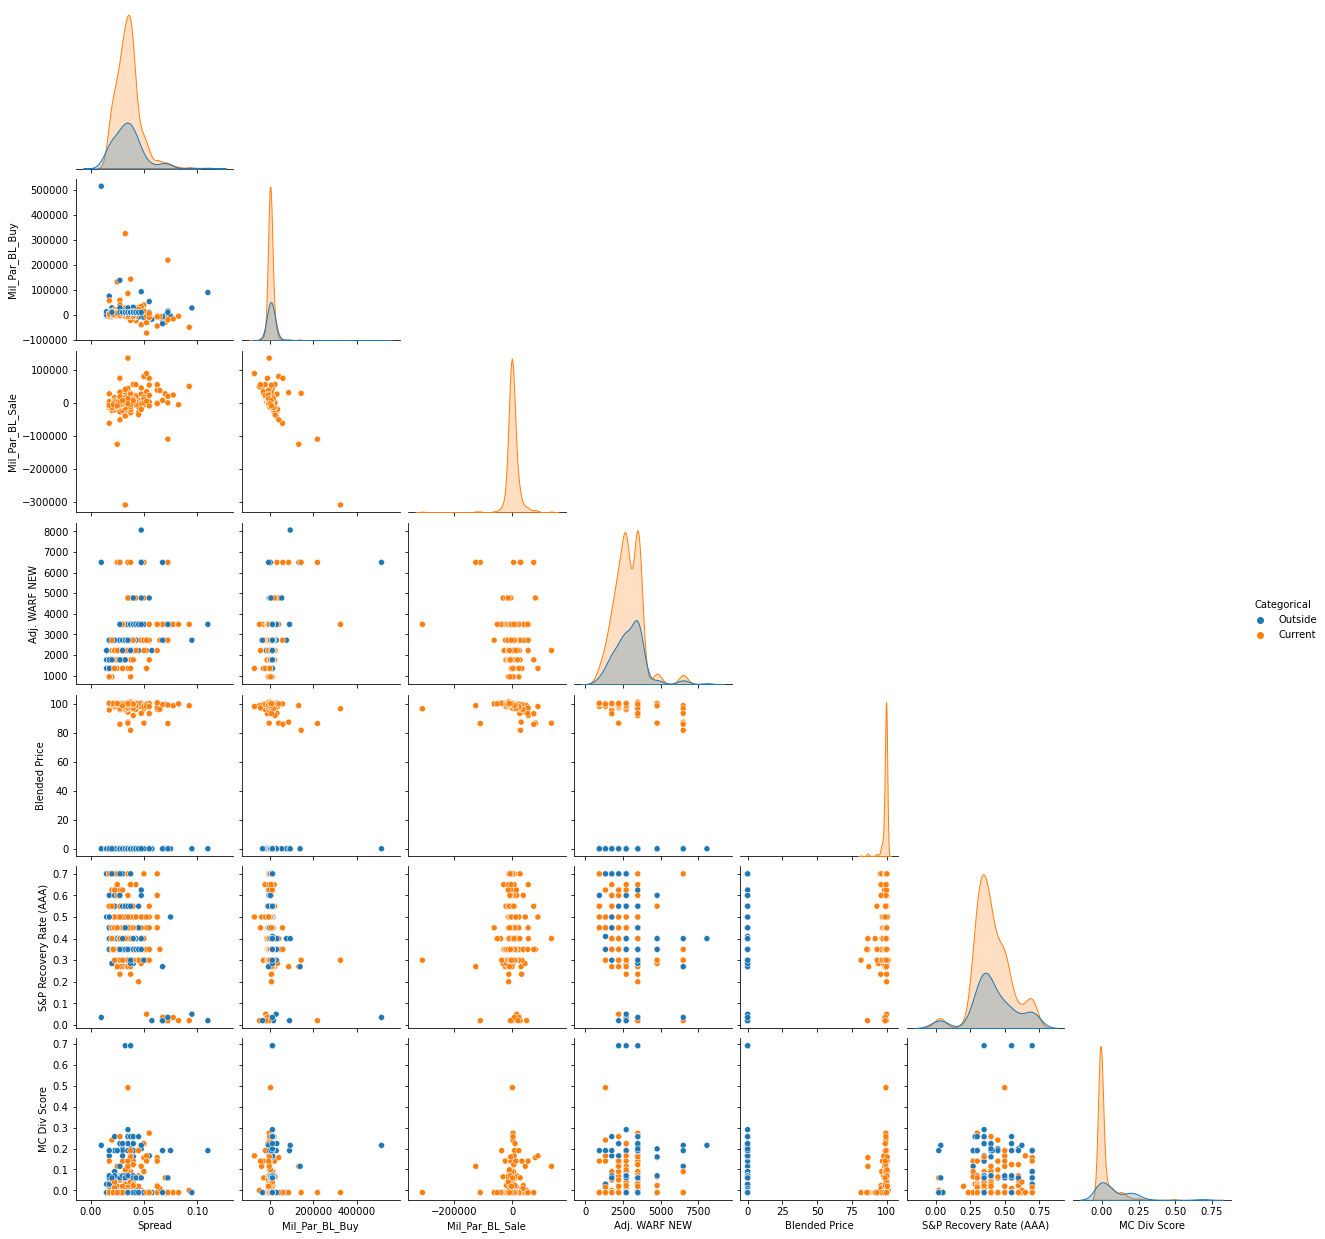

In [32]:
sns_plot = sns.pairplot(model_port[['Spread','Mil_Par_BL_Buy','Mil_Par_BL_Sale',
                                    'Adj. WARF NEW','Blended Price','S&P Recovery Rate (AAA)','MC Div Score','Categorical']],
                        diag_kind="kde",corner = True, hue='Categorical')  #, diag_kind='kde'
fig = sns_plot.fig
fig.savefig(path + "CLO_feature_PairPlot.png")

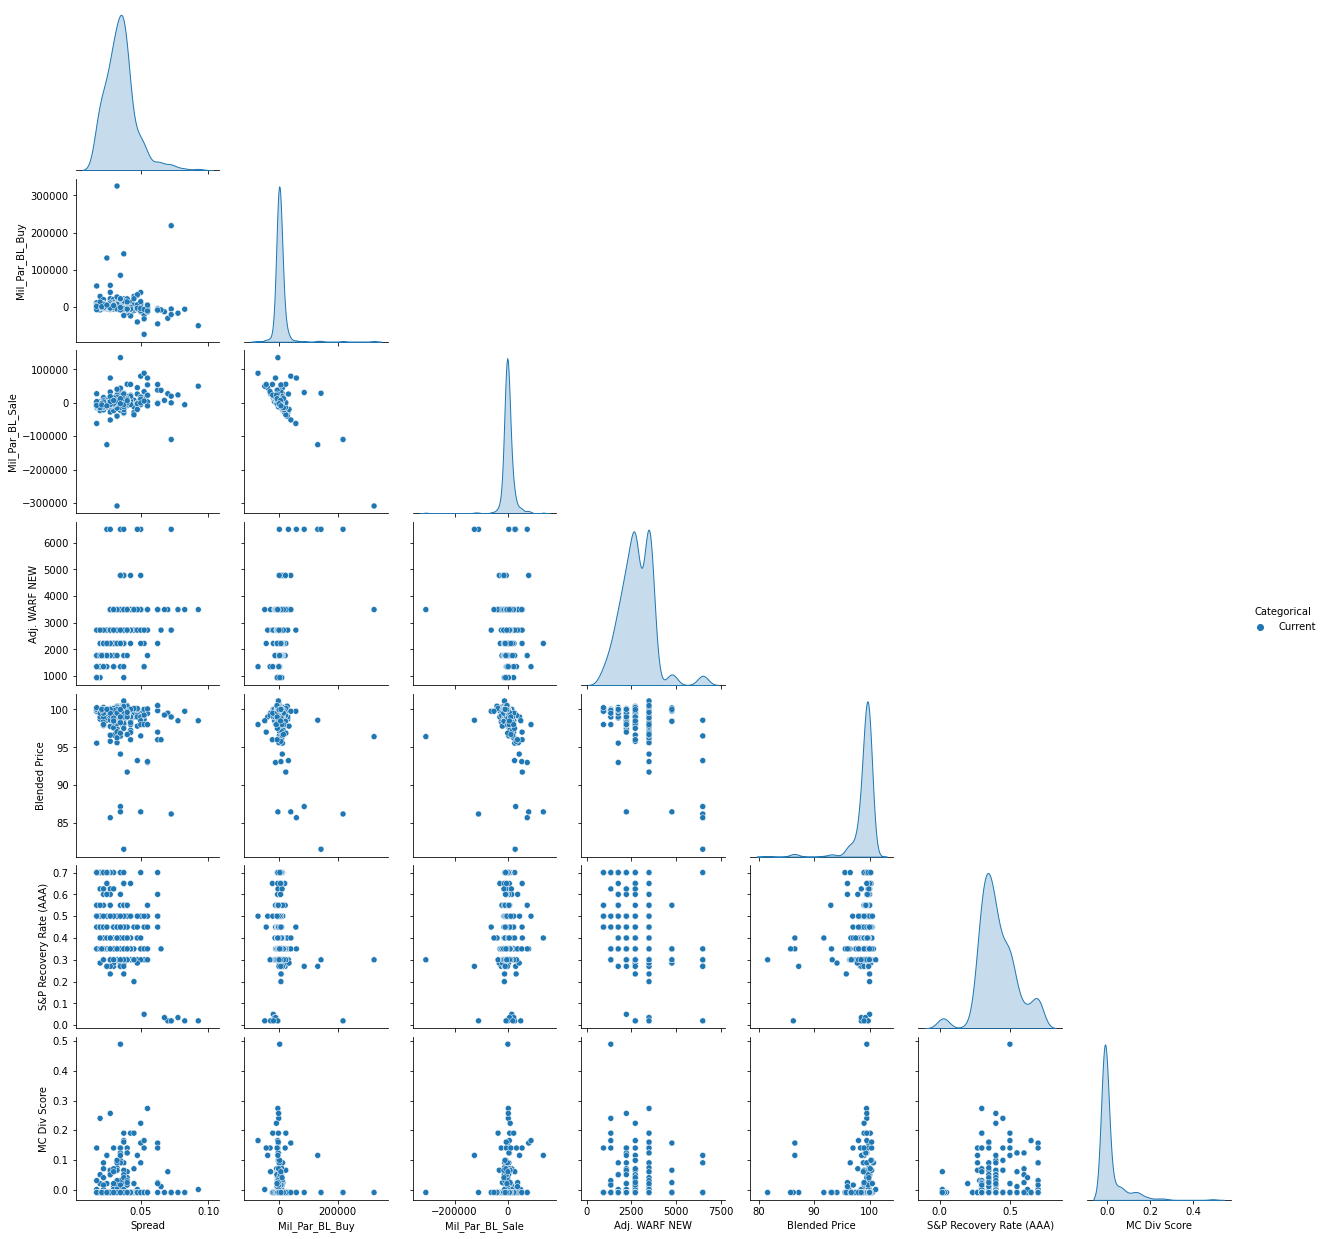

In [43]:
sns_plot = sns.pairplot(model_port.loc[model_port['Categorical']=='Current',['Spread','Mil_Par_BL_Buy','Mil_Par_BL_Sale',
                                    'Adj. WARF NEW','Blended Price','S&P Recovery Rate (AAA)',
                                    'MC Div Score','Categorical']],
                        diag_kind="kde",corner = True, hue='Categorical')  #, diag_kind='kde'

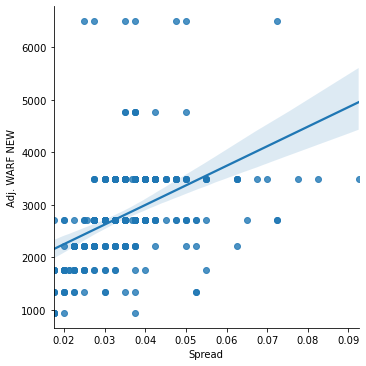

In [45]:
#sns.scatterplot(x = "Spread", y = "Adj. WARF NEW", data=model_port.loc[model_port['Categorical']=='Current'])
sns.lmplot(x = "Spread", y = "Adj. WARF NEW", data=model_port.loc[model_port['Categorical']=='Current'])

## Pairplot of Key Marginal Stats

C:\Users\jknechtel\Miniconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\jknechtel\Miniconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\jknechtel\Miniconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


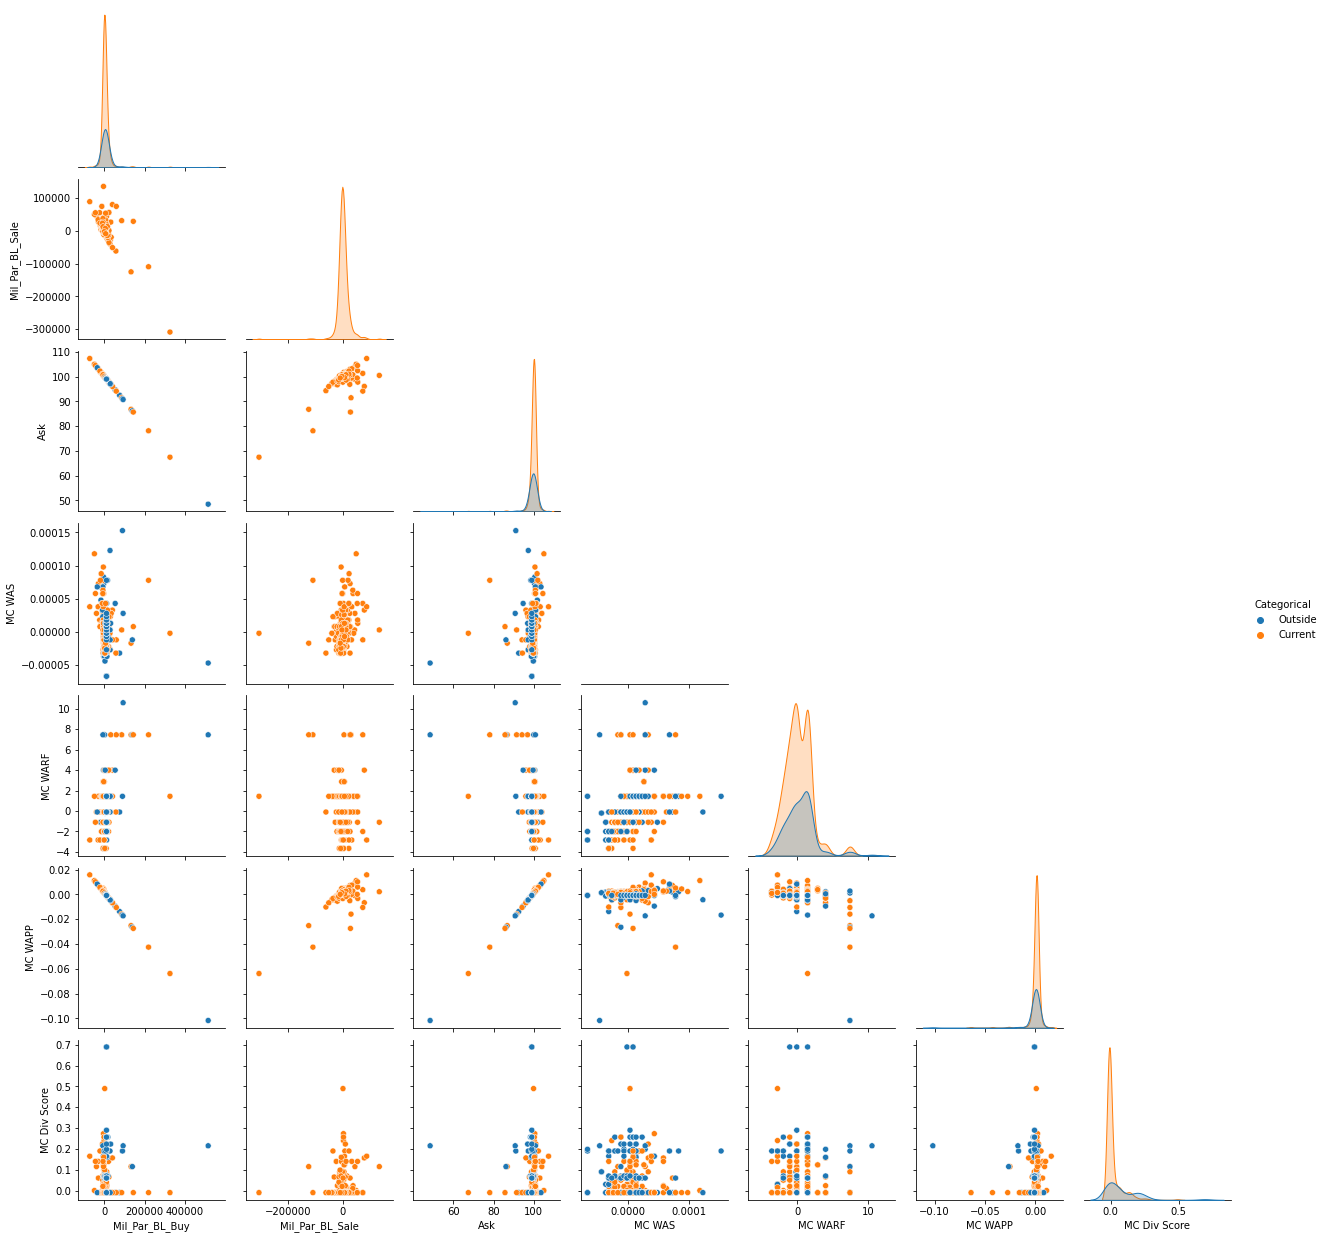

In [33]:
sns_plot = sns.pairplot(model_port[['Mil_Par_BL_Buy','Mil_Par_BL_Sale','Ask',
                                    'MC WAS','MC WARF','MC WAPP','MC Div Score','Categorical']], 
                        diag_kind="kde",corner = True,hue='Categorical')  #, diag_kind='kde'
fig = sns_plot.fig
fig.savefig(path + "CLO_Marginal_feature_PairPlot.png")

In [34]:
corr = model_port[['Spread','Mil_Par_BL_Buy','Mil_Par_BL_Sale','Ask',
                    'S&P Recovery Rate (AAA)','Adj. WARF NEW','Blended Price']].corr()
#pd.options.display.float_format = "{:,.2}".format
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,Spread,Mil_Par_BL_Buy,Mil_Par_BL_Sale,Ask,S&P Recovery Rate (AAA),Adj. WARF NEW,Blended Price
Spread,1.00,-0.10,0.22,0.10,-0.50,0.44,-0.02
Mil_Par_BL_Buy,-0.10,1.00,-0.70,-1.00,-0.17,0.39,-0.09
Mil_Par_BL_Sale,0.22,-0.70,1.00,0.70,0.04,-0.09,-0.33
Ask,0.10,-1.00,0.70,1.00,0.17,-0.39,0.09
S&P Recovery Rate (AAA),-0.50,-0.17,0.04,0.17,1.00,-0.36,-0.01
Adj. WARF NEW,0.44,0.39,-0.09,-0.39,-0.36,1.00,-0.08
Blended Price,-0.02,-0.09,-0.33,0.09,-0.01,-0.08,1.00


In [35]:
mcorr = model_port[['Mil_Par_BL_Buy','Mil_Par_BL_Sale','Ask',
                                    'MC WAS','MC WARF','MC WAPP','MC Div Score']].corr()
#pd.options.display.float_format = "{:,.2}".format
mcorr.style.background_gradient(cmap='coolwarm').set_precision(2)

,Mil_Par_BL_Buy,Mil_Par_BL_Sale,Ask,MC WAS,MC WARF,MC WAPP,MC Div Score
Mil_Par_BL_Buy,1.00,-0.70,-1.00,-0.10,0.38,-1.00,0.07
Mil_Par_BL_Sale,-0.70,1.00,0.70,0.22,-0.09,0.69,0.09
Ask,-1.00,0.70,1.00,0.10,-0.38,1.00,-0.07
MC WAS,-0.10,0.22,0.10,1.00,0.44,0.10,0.04
MC WARF,0.38,-0.09,-0.38,0.44,1.00,-0.38,0.08
MC WAPP,-1.00,0.69,1.00,0.10,-0.38,1.00,-0.07
MC Div Score,0.07,0.09,-0.07,0.04,0.08,-0.07,1.00


# Screening

- goals = higher spread

types of queries?

- how do I raise my WAS by 5 bps and not burn more than 2mm in par

- how to I lower my WARF score without losing spread, or buring par, but willing to sacrifice other things?

- how can I raise my spread but not go above 3200 on WARF, or below 50 on diversity score?




In [57]:
# grab the current portfolio stats from above and create a splice where "spread"> current WAS

model_port[['Spread','Total_Par_Build_Loss','Adj. WARF NEW',
            'Parent Company','Moodys Industry','Par_no_default']].sort_values(by='Spread',ascending=False)

,Spread,Total_Par_Build_Loss,Adj. WARF NEW,Parent Company,Moodys Industry,Par_no_default
LXID,,,,,,
LX187441,0.1100,0,3490.0,"Constellis Holdings, LLC",Aerospace & Defense,0.00
LX169474,0.0950,0,2720.0,"Research Now Group, Inc.",Services: Business,0.00
LX192625,0.0925,0,3490.0,Dynacast (Form Technologies),Capital Equipment,357971.95
LX181831,0.0825,0,3490.0,MyEyeDr,Retail Stores,250000.00
LX191924,0.0775,0,3490.0,ICP Group Holdings,"Chemicals, Plastics, & Rubber",249000.00
...,...,...,...,...,...,...
USU6835WAA28,NaN,0,1350.0,Organon Finance 1 LLC,Healthcare & Pharmaceuticals,0.00
USC6900PAL34,NaN,0,1766.0,Restaurant Brands,"Beverage, Food, & Tobacco",0.00
USU9094LAD02,NaN,0,1350.0,"United AirLines, Inc.",Transportation: Consumer,0.00


## E.g. 1, How do I raise my WAS by 5 bps and not burn more than 2mm in Par?

In [80]:
Port_stats(model_port,ind_avg_eu)


,Portfolio Stats
Min Floating Spread Test - no Libor Floors,3.35%
Min Floating Spread Test - With Libor Floors,3.58%
Max Moodys Rating Factor Test (NEW WARF),2772
Max Moodys Rating Factor Test (Orig WARF),2944
Min Moodys Recovery Rate Test,48.2%
Min S&P Recovery Rate Class A-1a,41.7%
Moodys Diversity Test,88
WAP,$99.01
Percent C,3.8%
Percent 2nd Lien,0.8%


In [59]:
# these work but are slightly slower
#float(pstats.loc['Min Floating Spread Test - no Libor Floors'].strip('%').to_numpy()[0])/100
#pstats.loc['Min Floating Spread Test - no Libor Floors'].str.strip('%').astype(float)[0]/100
#float(pstats.loc['Min Floating Spread Test - no Libor Floors','Portfolio Stats'].strip('%'))/100

# Most desired, i.e. list to buy
len(model_port.loc[(model_port['Categorical']=='Outside')&\
                               (model_port['Spread']>0.0335383475931462)&(model_port['Adj. WARF NEW']<3200),
                    ['Parent Company','Moodys Industry','Spread','Adj. WARF NEW',
            'Mil_Par_BL_Sale','Mil_Par_BL_Buy','MC Div Score','Desirability']].sort_values(by=['Desirability'],ascending=False))
model_port.loc[(model_port['Categorical']=='Outside')&\
                               (model_port['Spread']>0.0335383475931462)&(model_port['Adj. WARF NEW']<3200),
                    ['Mil_Par_BL_Buy']].sum()

16

Mil_Par_BL_Buy   -7250.0
dtype: float64

In [60]:
#model_port['Categorical']

# least desired, list to sell
len(model_port.loc[(model_port['Categorical']=='Current')&\
                               (model_port['Spread']<.035)&(model_port['Adj. WARF NEW']>3200),
                    ['Parent Company','Moodys Industry','Spread','Adj. WARF NEW',
            'Mil_Par_BL_Sale','Mil_Par_BL_Buy','MC Div Score','Desirability']].sort_values(by=['Desirability'])) #,ascending=False
model_port.loc[(model_port['Categorical']=='Current')&\
                               (model_port['Spread']<.035)&(model_port['Adj. WARF NEW']>3200),
                    ['Mil_Par_BL_Sale']].sum()

26

Mil_Par_BL_Sale   -434770.0
dtype: float64

In [74]:
def raise_WAS(model_df,WAS_lift=0.0005,Parburn_crit=2e6):
    
    ####### Starting Key Stats ####################
    # Let's keep track of pre-trade key stats to compare
    # These should match the pstats from 'Current Portfolio'
    pre_WAS = weighted_average(model_df,cols=['Par_no_default','Spread'])
    target_WAS = pre_WAS + WAS_lift
    pre_WARF = weighted_average(model_df,cols=['Par_no_default','Adj. WARF NEW'])
    pre_dScore = diversity_score(model_df,ind_avg_eu,'Par_no_default')
    print('Pre Trade Stats, WAS: ',pre_WAS,' Target WAS: ',target_WAS,' WARF: ', pre_WARF,' DivScore: ', pre_dScore)

    ####### Potential Trade list ####################
    # technically we just want to rank by highest WAS/lowest parburn  (value/weight)
    pot_sales = model_df.loc[(model_df['Categorical']=='Current')&\
                            (model_df['Spread']<pre_WAS)&(model_df['Adj. WARF NEW']>3200)]\
                            .sort_values(by=['Desirability']).index.tolist() 
    # buys don't have to be outside!
    pot_buys = model_df.loc[(model_df['Categorical']=='Outside')&\
                            (model_df['Spread']>pre_WAS)&(model_df['Adj. WARF NEW']<3200)]\
                            .sort_values(by=['Desirability'],ascending=False).index.tolist()

    ####### Initial Conditions ####################
    curr_port = model_df.loc[(model_df['Categorical']=='Current')].index.tolist()
    new_port = curr_port.copy()  # start with the current portfolio
    parburn = 0 
    trades = 0
    model_df['PnD_postTrade'] = model_df['Par_no_default']

    for trades in range(min(len(pot_sales),len(pot_buys))):
    
        #let's start with one sale, one buy for now
        # need to actually calculate the burn for actual trade size
        trade_size = min(model_df.loc[pot_sales[trades],'Par_no_default'],1e6)
        
        print("Trade Set #",trades+1)
        parburn += model_df.loc[pot_sales[trades],'Mil_Par_BL_Sale']
        print(pot_sales[trades],parburn)
        # can't use this because the sales isn't sized the same, need to calc actual parburn
        parburn += model_df.loc[pot_buys[trades],'Mil_Par_BL_Buy']*trade_size/1e6
        print(pot_buys[trades],parburn)
        
        if (parburn <= -Parburn_crit):
            print(parburn, post_WAS)
            break
        else:
            # need to make cash neutral trades
            # could instead keep a running sum of trades and match buys at the end
            model_df.loc[pot_sales[trades],'PnD_postTrade'] = \
                model_df.loc[pot_sales[trades],'Par_no_default'] - trade_size 
            model_df.loc[pot_buys[trades],'PnD_postTrade'] = \
                model_df.loc[pot_buys[trades],'Par_no_default'] + trade_size  #match the sell amount
            
            model_df.loc[pot_sales[trades],'Trade'] = 'Sale'
            new_port.remove(pot_sales[trades])   
            model_df.loc[pot_buys[trades],'Trade'] = 'Buy'
            new_port.append(pot_buys[trades])   
                                    
            post_WAS = weighted_average(model_df.loc[new_port],cols=['PnD_postTrade','Spread'])
            post_dScore = diversity_score(model_df,ind_avg_eu,'PnD_postTrade')
            post_WARF = weighted_average(model_df,cols=['PnD_postTrade','Adj. WARF NEW'])
            
            print('Sale: ',pot_sales[trades],' Buy: ', pot_buys[trades])
            print('Post Stats, WAS: ',post_WAS,' WARF: ', post_WARF,' DivScore: ', post_dScore)
            trades += 1
            
            if (post_WAS >= target_WAS)|(post_dScore <= 50):
                print('Target met: ',(post_WAS >= target_WAS),' or Diversity breached: ', (post_dScore <= 50))
                print('Total Par Burn: ',parburn,'', post_WAS, post_dScore)
                break
            
        
    return new_port, curr_port #, sales, buys



In [75]:
new, curr = raise_WAS(model_port,WAS_lift=0.0005,Parburn_crit=2e6)

#curr
new == curr
len(new)
len(curr)

Pre Trade Stats, WAS:  0.0335383475931462  Target WAS:  0.0340383475931462  WARF:  2771.7540435027026  DivScore:  88.2333
Trade Set # 1
LX176167 -22730.0
LXREP12 -12730.0
Sale:  LX176167  Buy:  LXREP12
Post Stats, WAS:  0.03358307317473401  WARF:  2769.210500237562  DivScore:  88.9033
Trade Set # 2
LX180276 -14600.0
LXREP11 -4600.0
Sale:  LX180276  Buy:  LXREP11
Post Stats, WAS:  0.033592325653512146  WARF:  2767.6683519586973  DivScore:  89.2033
Trade Set # 3
LX173270 20230.0
LXREP10 26612.7074
Sale:  LX173270  Buy:  LXREP10
Post Stats, WAS:  0.03359552874600185  WARF:  2766.684043835557  DivScore:  89.2533
Trade Set # 4
LX173185 34342.7074
LXREP9 44342.7074
Sale:  LX173185  Buy:  LXREP9
Post Stats, WAS:  0.03361253388687681  WARF:  2765.141895556692  DivScore:  89.17830000000001
Trade Set # 5
LX167679 38142.7074
LX188807 3040.2197847999996
Sale:  LX167679  Buy:  LX188807
Post Stats, WAS:  0.03368149784863646  WARF:  2763.6310599200847  DivScore:  89.17830000000001
Trade Set # 6
LX171

False

343

343

In [76]:
# this is just a check

model_port.loc['LX173270',['Par_no_default','PnD_postTrade']]
min(model_port.loc['LX173270','Par_no_default'],1e6)

model_port.loc['LX173270','PnD_postTrade'] = model_port.loc['LX173270','Par_no_default'] - \
                min(model_port.loc['LX173270','Par_no_default'],1e6)
model_port.loc['LX173270','PnD_postTrade']

Par_no_default    638270.74
PnD_postTrade           0.0
Name: LX173270, dtype: object

638270.74

0.0

In [77]:
model_port.loc[~model_port['Trade'].isna(),['Trade','Par_no_default','PnD_postTrade']]
model_port.loc[~model_port['Trade'].isna(),['Trade','Par_no_default','PnD_postTrade']].sum()

,Trade,Par_no_default,PnD_postTrade
LXID,,,
LX185280,Buy,0.00,1000000.00
LX190032,Buy,0.00,1000000.00
LX173270,Sale,638270.74,0.00
LX180276,Sale,2947500.00,1947500.00
LX192681,Buy,0.00,1000000.00
LX178613,Buy,0.00,175619.29
LX173185,Sale,1960934.92,960934.92
LX171005,Buy,0.00,1000000.00
LX167679,Sale,979695.44,0.00


Trade             BuyBuySaleSaleBuyBuySaleBuySaleBuySaleSaleSale...
Par_no_default                                          23678078.79
PnD_postTrade                                           23678078.79
dtype: object

In [81]:
prepost_Port_stats(model_port, ind_avg_eu, ['Par_no_default','PnD_postTrade'])

,Current Portfolio (pre-trade),Post-trade Portfolio
Min Floating Spread Test - no Libor Floors,3.35%,3.40%
Min Floating Spread Test - With Libor Floors,3.58%,3.64%
Max Moodys Rating Factor Test (NEW WARF),2772,2742
Max Moodys Rating Factor Test (Orig WARF),2944,2900
Min Moodys Recovery Rate Test,48.2%,47.8%
Min S&P Recovery Rate Class A-1a,41.7%,41.6%
Moodys Diversity Test,85,89
WAP,$99.01,$96.24
Percent C,3.8%,3.6%
Percent 2nd Lien,0.8%,1.6%


## E.g. 2, How to I lower my WARF score without losing spread, or buring par, but willing to sacrifice other things?

In [62]:
model_port.loc[(model_port['MC WARF']<0)&(model_port['Mil_Par_BL_Buy']>0)&(model_port['MC WAS']>0),
               ['Spread','MC WAS','Total_Par_Build_Loss','Adj. WARF NEW',
            'Parent Company','Moodys Industry','Mil_Par_BL_Buy']].sort_values(by='Spread',ascending=False)

,Spread,MC WAS,Total_Par_Build_Loss,Adj. WARF NEW,Parent Company,Moodys Industry,Mil_Par_BL_Buy
LXID,,,,,,,
LX169474,0.095000,0.000123,0,2720.0,"Research Now Group, Inc.",Services: Business,27500.0
LX169473,0.055000,0.000043,0,2720.0,"Research Now Group, Inc.",Services: Business,210.0
LX179530,0.050000,0.000033,0,2220.0,"Staples, Inc.",Services: Business,14790.0
LX192522,0.047500,0.000028,0,2720.0,Jadex Inc.,Consumer Goods: Non-durable,6250.0
LX179819,0.045000,0.000023,0,2220.0,"Staples, Inc.",Services: Business,4170.0
LX177119,0.042500,0.000018,0,2720.0,"Plaskolite, LLC",Construction & Building,10000.0
LX192641,0.037500,0.000008,0,2720.0,"National Mentor Holdings, Inc. (aka Civitas So...",Healthcare & Pharmaceuticals,250.0
LX192640,0.037500,0.000008,0,2720.0,"National Mentor Holdings, Inc. (aka Civitas So...",Healthcare & Pharmaceuticals,250.0
LXREP12,0.037500,0.000008,0,2220.0,LXREP12,Automotive,10000.0


In [84]:
def lower_WARF(model_df,target_WARF,Parburn_crit=0):
    
    ####### Starting Key Stats ####################
    # Let's keep track of pre-trade key stats to compare
    # These should match the pstats from 'Current Portfolio'
    pre_WAS = weighted_average(model_df,cols=['Par_no_default','Spread'])
    
    pre_WARF = weighted_average(model_df,cols=['Par_no_default','Adj. WARF NEW'])

    pre_dScore = diversity_score(model_df,ind_avg_eu,'Par_no_default')
    print('Pre Trade Stats, WARF: ',pre_WARF,' Target WARF: ',target_WARF,' WAS: ', pre_WAS,' DivScore: ', pre_dScore)

    ####### Potential Trade list ####################
    # technically we just want to rank by highest WAS/lowest parburn  (value/weight)
    
    (model_port['MC WARF']<0)&(model_port['Mil_Par_BL_Buy']>0)&(model_port['MC WAS']>0)
    
    pot_sales = model_df.loc[(model_df['Categorical']=='Current')&\
                            (model_port['MC WARF']<0)&(model_port['Mil_Par_BL_Sale']>0)&(model_port['MC WAS']>0)]\
                            .sort_values(by=['Desirability']).index.tolist() 
    # buys don't have to be outside!
    pot_buys = model_df.loc[(model_df['Categorical']=='Outside')&\
                            (model_port['MC WARF']<0)&(model_port['Mil_Par_BL_Buy']>0)&(model_port['MC WAS']>0)]\
                            .sort_values(by=['Desirability'],ascending=False).index.tolist()

    ####### Initial Conditions ####################
    curr_port = model_df.loc[(model_df['Categorical']=='Current')].index.tolist()
    new_port = curr_port.copy()  # start with the current portfolio
    parburn = 0 
    trades = 0
    model_df['PnD_postTrade'] = model_df['Par_no_default']

    for trades in range(min(len(pot_sales),len(pot_buys))):
    
        #let's start with one sale, one buy for now
        # need to actually calculate the burn for actual trade size
        trade_size = min(model_df.loc[pot_sales[trades],'Par_no_default'],1e6)
        
        print("Trade Set #",trades+1)
        parburn += model_df.loc[pot_sales[trades],'Mil_Par_BL_Sale']
        print(pot_sales[trades],parburn)
        # can't use this because the sales isn't sized the same, need to calc actual parburn
        parburn += model_df.loc[pot_buys[trades],'Mil_Par_BL_Buy']*trade_size/1e6
        print(pot_buys[trades],parburn)
        
        if (parburn <= -Parburn_crit):
            print(parburn, post_WAS)
            break
        else:
            # need to make cash neutral trades
            # could instead keep a running sum of trades and match buys at the end
            model_df.loc[pot_sales[trades],'PnD_postTrade'] = \
                model_df.loc[pot_sales[trades],'Par_no_default'] - trade_size 
            model_df.loc[pot_buys[trades],'PnD_postTrade'] = \
                model_df.loc[pot_buys[trades],'Par_no_default'] + trade_size  #match the sell amount
            
            model_df.loc[pot_sales[trades],'Trade'] = 'Sale'
            new_port.remove(pot_sales[trades])   
            model_df.loc[pot_buys[trades],'Trade'] = 'Buy'
            new_port.append(pot_buys[trades])   
                                    
            post_WAS = weighted_average(model_df.loc[new_port],cols=['PnD_postTrade','Spread'])
            post_dScore = diversity_score(model_df,ind_avg_eu,'PnD_postTrade')
            post_WARF = weighted_average(model_df,cols=['PnD_postTrade','Adj. WARF NEW'])
            
            print('Sale: ',pot_sales[trades],' Buy: ', pot_buys[trades])
            print('Post Stats, WAS: ',post_WAS,' WARF: ', post_WARF,' DivScore: ', post_dScore)
            trades += 1
            
            if (post_WARF <= target_WARF)|(post_dScore <= 50):stud
                print('Target met: ',(post_WARF <= target_WARF),' or Diversity breached: ', (post_dScore <= 50))
                print('Total Par Burn: ',parburn,'', post_WARF, post_WAS, post_dScore)
                break
            
        
    return new_port, curr_port #, sales, buys



In [85]:
lower_WARF(model_port,2700,Parburn_crit=0)

Pre Trade Stats, WARF:  2771.7540435027026  Target WARF:  2700  WAS:  0.0335383475931462  DivScore:  88.2333
Trade Set # 1
LX193380 45380.0
LXREP12 52880.0
Sale:  LX193380  Buy:  LXREP12
Post Stats, WAS:  0.033546256085290445  WARF:  2771.002997262996  DivScore:  88.7
Trade Set # 2
LX193604 58510.0
LXREP11 68510.0
Sale:  LX193604  Buy:  LXREP11
Post Stats, WAS:  0.03353631497367687  WARF:  2772.9136588968104  DivScore:  89.0
Trade Set # 3
LX192466 69590.0
LXREP10 76060.0
Sale:  LX192466  Buy:  LXREP10
Post Stats, WAS:  0.033529850810129797  WARF:  2772.9136588968104  DivScore:  89.0
Trade Set # 4
LX193944 78250.0
LXREP9 88250.0
Sale:  LX193944  Buy:  LXREP9
Post Stats, WAS:  0.033529251285961105  WARF:  2772.9136588968104  DivScore:  88.92
Trade Set # 5
LX185949 101270.0
LX179819 105440.0
Sale:  LX185949  Buy:  LX179819
Post Stats, WAS:  0.03343446345871112  WARF:  2771.9122639105344  DivScore:  88.92
Trade Set # 6
LX174852 114800.0
LX169474 142300.0
Sale:  LX174852  Buy:  LX169474
Pos

(['LX175827',
  'LX191328',
  'LX190422',
  'LX172001',
  'LX189365',
  'LX192164',
  'LX173270',
  'LX180276',
  'LX181046',
  'LX168956',
  'LX169002',
  'LX162009',
  'LX161695',
  'LX176335',
  'LX183042',
  'LX192319',
  'LX169521',
  'LX165158',
  'LX161296',
  'LX192222',
  'LX190069',
  'LX192672',
  'LX172008',
  'LX184502',
  'LX192678',
  'LX190953',
  'LX191415',
  'LX192293',
  'LX192294',
  'LX192386',
  'LX167796',
  'LX185324',
  'LX155666',
  'LX193607',
  'LX193330',
  'LX192780',
  'LX190026',
  'LX190972',
  'LX191084',
  'LX171510',
  'LX173606',
  'LX177019',
  'LX169049',
  'LX176839',
  'LX193821',
  'LX173185',
  'LX159354',
  'LX171003',
  'LX175350',
  'LX175374',
  'LX165183',
  'LX192971',
  'LX185399',
  'LX190093',
  'LX175317',
  'LX192094',
  'LX192343',
  'LX168784',
  'LX185309',
  'LX170204',
  'LX179355',
  'LX182073',
  'LX191933',
  'LX191935',
  'LX167679',
  'LX177794',
  'LX192894',
  'LX152766',
  'LX175452',
  'LX159695',
  'LX183544',
  'LX1

## E.g. 3, How can I raise my spread but not go above 3200 on WARF, or below 50 on diversity score?

In [63]:
model_port.loc[(model_port['MC WAS']>0)&(model_port['Adj. WARF NEW']<3400)&(model_port['MC Div Score']>0),
               ['Spread','MC WAS','Total_Par_Build_Loss','Adj. WARF NEW',
            'Parent Company','Moodys Industry','Mil_Par_BL_Buy']].sort_values(by='Spread',ascending=False)

,Spread,MC WAS,Total_Par_Build_Loss,Adj. WARF NEW,Parent Company,Moodys Industry,Mil_Par_BL_Buy
LXID,,,,,,,
LX191236,0.0650,0.000063,0,2720.0,Syncapay,High Tech Industries,-7500.0
LX190612,0.0625,0.000058,0,2220.0,"MSG National Properties, LLC","Hotel, Gaming, & Leisure",-45000.0
LX188714,0.0525,0.000038,0,1350.0,JetBlue Airways Corporation,Aerospace & Defense,-31670.0
LX188905,0.0525,0.000038,0,1350.0,"United AirLines, Inc.",Aerospace & Defense,-73130.0
LX192269,0.0500,0.000033,0,2720.0,"Lew's Intermediate Holdings, LLC",Consumer Goods: Durable,-10000.0
LX193380,0.0475,0.000028,0,2720.0,AAdvantage Loyalty IP Ltd.,Aerospace & Defense,-39880.0
LX193607,0.0450,0.000023,0,2720.0,"Autokiniton US Holdings, Inc. (aka L&W, Inc.)",Automobile,-9170.0
LX190112,0.0400,0.000013,0,2720.0,"White Cap Buyer, LLC",Construction & Building,-4090.0
LX193256,0.0400,0.000013,0,2720.0,Vertex Aerospace LLC,Aerospace & Defense,-2810.0


## E.g. 4, How about potential Sells

In [40]:

model_port.loc[(model_port['MC WAS']<0)&(model_port['Mil_Par_BL_Sale']>0),
               ['Parent Company','Moodys Industry','Spread','MC WAS','Adj. WARF NEW',
            'Mil_Par_BL_Sale','Mil_Par_BL_Buy','MC Div Score']].sort_values(by=['Moodys Industry','Spread'],ascending=False)

,Parent Company,Moodys Industry,Spread,MC WAS,Adj. WARF NEW,Mil_Par_BL_Sale,Mil_Par_BL_Buy,MC Div Score
LXID,,,,,,,,
LX181464,Genesee & Wyoming Inc.,Transportation: Cargo,0.0200,-0.000027,1350.0,2920.0,-1940.0,0.2400
LX185593,"Zayo Group Holdings, Inc.",Telecommunications,0.0300,-0.000007,2720.0,7120.0,4100.0,-0.0100
LX192038,Iridium Satellite LLC,Telecommunications,0.0275,-0.000012,1766.0,1810.0,-6110.0,-0.0100
LX189365,Alight (Tempo),Services: Business,0.0325,-0.000002,2220.0,24570.0,-2920.0,-0.0100
LX183287,ProQuest LLC (fka ProQuest-CSA LLC),Services: Business,0.0325,-0.000002,2720.0,350.0,3000.0,-0.0100
LX190422,Adevinta ASA,Services: Business,0.0300,-0.000007,1766.0,9690.0,-4380.0,-0.0100
LX190007,Clarivate (aka Camelot U.S. Acquisition),Services: Business,0.0300,-0.000007,2720.0,2400.0,-5200.0,-0.0100
LX170802,Prometric Holdings Inc. (fka ETS Holdings Inc.),Services: Business,0.0300,-0.000007,3490.0,2350.0,7250.0,-0.0100
LX193556,WEX Inc.,Services: Business,0.0225,-0.000022,1350.0,2500.0,-1610.0,-0.0100


In [65]:
model_port.loc[(model_port['Spread']<0.035)&(model_port['Adj. WARF NEW']>3200)&(model_port['Current Portfolio']>0),
               ['Spread','MC WAS','Current Portfolio','Adj. WARF NEW',
            'Parent Company','Moodys Industry','Mil_Par_BL_Sale']].sort_values(by='Spread',ascending=False)

,Spread,MC WAS,Current Portfolio,Adj. WARF NEW,Parent Company,Moodys Industry,Mil_Par_BL_Sale
LXID,,,,,,,
LX173270,0.0325,-0.000002,638270.74,3490.0,"Alliant Holdings Intermediate, LLC","Banking, Finance, Insurance & Real Estate",24830.0
LX171798,0.0325,-0.000002,2695127.40,3490.0,Mavis Tire Express Services Corp.,Consumer Goods: Durable,40860.0
LX185376,0.0325,-0.000002,1635888.87,3490.0,Tank Holding Corp.,"Containers, Packaging, & Glass",-15810.0
LX176786,0.0325,-0.000002,1959899.76,3490.0,"Sedgwick Claims Management Services, Inc. (Lig...",Services: Business,-6710.0
LX174279,0.0325,-0.000002,738825.30,3490.0,Novolex,"Containers, Packaging, & Glass",15180.0
LX179693,0.0325,-0.000002,842855.33,3490.0,Momentive Performance Materials USA Inc.,"Chemicals, Plastics, & Rubber",-10130.0
LX169555,0.0325,-0.000002,1227848.08,3490.0,"Mitchell International, Inc.","Banking, Finance, Insurance & Real Estate",22920.0
LX180276,0.0325,-0.000002,2947500.00,3490.0,"Alliant Holdings Intermediate, LLC","Banking, Finance, Insurance & Real Estate",-1870.0
LX183345,0.0325,-0.000002,175619.29,3490.0,Merlin Entertainments (aka Motion Acquisition ...,"Hotel, Gaming, & Leisure",-39720.0


# Optimization 
( or Creating Baskets of Buys/Sales)

Notes:
- Compare Screening to actual optimization methods
- Knapsack problem is often solved via dynamic programming
- Can be posed as a MIP problem for efficiency apparently
- Lots of good MIP optimizers like CVXPY
- How do we deal with a vector of constraints rather than scalar in the DP problem?
- Given the higher dimensionality, Gradient Descent could prove more useful
- Optimal solution might need to be a space of optimality rather than a fixed set of trades;
- like uncertainty around optimality akin to the cloud around efficient frontier;
- Is there a Bayesian style posing of the problem/solution?
- How do we a priori figure out what are the feasible trade sizes (notionals)?


# Extra Stuff, Testing


In [35]:
screen_one = (model_port['MC WAS']>0)&(model_port['Mil_Par_BL_Buy']>0)
model_port.loc[screen_one, ['Spread','MC WAS','Total_Par_Build_Loss','Adj. WARF NEW',
            'Parent Company','Moodys Industry','Mil_Par_BL_Buy']].sort_values(by='Spread',ascending=False)
#Port_stats(model_port.loc[screen_one],ind_avg_eu) #not correct

,Spread,MC WAS,Total_Par_Build_Loss,Adj. WARF NEW,Parent Company,Moodys Industry,Mil_Par_BL_Buy
LXID,,,,,,,
LX187441,0.1100,0.000153,0,3490.0,"Constellis Holdings, LLC",Aerospace & Defense,89330.0
LX169474,0.0950,0.000123,0,2720.0,"Research Now Group, Inc.",Services: Business,27500.0
LXREP26,0.0725,0.000078,0,3490.0,LXREP26,Capital Equipment,10000.0
LX171510,0.0725,0.000078,0,6500.0,"AVSC Holding Corp. (aka PSAV, Inc.)",Services: Business,218750.0
LX171490,0.0725,0.000078,0,3490.0,EaglePicher,Aerospace & Defense,15000.0
...,...,...,...,...,...,...,...
LX172789,0.0350,0.000003,0,3490.0,"Heartland Dental, LLC",Healthcare & Pharmaceuticals,5340.0
LX165896,0.0350,0.000003,0,3490.0,"Hoya Midco, LLC (aka Vivid Seats LLC)","Hotel, Gaming, & Leisure",10620.0
LX181488,0.0350,0.000003,0,3490.0,Press Ganey (Azalea),Healthcare & Pharmaceuticals,3540.0


In [66]:

# this has NaT's for some reason, also not likely what is used in WAL test
def WAL(model_df):  
    wal = (model_df['Par_no_default']*(model_df['Maturity']-pd.Timestamp.today())).sum()/model_df['Par_no_default'].sum()*100
    return wal

#def OC_test():
#    return

#def IC_test():
#    return

In [204]:
def desirability(model_df,keyStats,weights,highLow):
    #norm_df = model_df.copy()
    #norm_df = (norm_df[keyStats]-norm_df[keyStats].mean())/norm_df[keyStats].std()
    #norm_df = (model_df[keyStats]-model_df[keyStats].mean())/model_df[keyStats].std()
    #desire = 
    return (((model_df[keyStats]-model_df[keyStats].mean())/model_df[keyStats].std())*(np.array(weights)*np.array(highLow))).sum(axis=1)
    
    #return desire

#model_df['Desirability'] 
#model_df['Desirability'] = ((model_df[keyStats]-model_df[keyStats].mean())/model_df[keyStats].std()*weights).sum(axis=1)
#test = desirability(model_port,keyStats,weights,highLow).values
#len(test)
model_port.loc[:,'Desirability'] = desirability(model_port,keyStats,weights,highLow).values

C:\Users\jknechtel\Miniconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [67]:
model_port[['Maturity']].info()
#model_port['Maturity']-pd.Timestamp.today()
WAL(model_port)

<class 'pandas.core.frame.DataFrame'>
Index: 491 entries, LX190245 to LXREP26
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Maturity  457 non-null    datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 23.8+ KB


C:\Users\jknechtel\Miniconda3\lib\site-packages\pandas\core\arrays\timedeltas.py:507: RuntimeWarning: invalid value encountered in multiply
  result = self._data * other


Timedelta('0 days 00:00:00')

In [68]:
def knapSack(W, wt, val, n): 
    K = [[0 for x in range(W + 1)] for x in range(n + 1)] 
   
    # Build table K[][] in bottom up manner 
    for i in range(n + 1): 
        for w in range(W + 1): 
            if i == 0 or w == 0: 
                K[i][w] = 0
            elif wt[i-1] <= w: 
                K[i][w] = max(val[i-1] 
                          + K[i-1][w-wt[i-1]],   
                              K[i-1][w]) 
            else: 
                K[i][w] = K[i-1][w] 
   
    return K[n][W] 
   
   
# Driver code 
val = [60, 100, 120] 
wt = [10, 20, 30] 
W = 400000000
n = len(val) 
print(knapSack(W, wt, val, n)) 

220


In [ ]:
def raise_WAS(model_df,WAS_lift=0.0005,Parburn_crit=2e6):
    curr_WAS = weighted_average(model_df,cols=['Par_no_default','Spread'])
    target_WAS = curr_WAS + WAS_lift
    #weighted_average(model_df,cols=['Par_no_default','Adj. WARF NEW'])
    #diversity_score(model_df,ind_avg_eu)

    pot_sales = model_df.loc[(model_df['Categorical']=='Current')&\
                               (model_df['Spread']<curr_WAS)&(model_df['Adj. WARF NEW']>3200)]\
                        .sort_values(by=['Desirability']).index.tolist() 
    pot_buys = model_df.loc[(model_df['Categorical']=='Outside')&\
                               (model_df['Spread']>curr_WAS)&(model_df['Adj. WARF NEW']<3200)]\
                        .sort_values(by=['Desirability'],ascending=False).index.tolist()
    
    #print('Sales: ',pot_sales)
    #print('Buys: ',pot_buys)
    
    curr_port = model_df.loc[(model_df['Categorical']=='Current')].index.tolist()
    #sales = []  #list of LXIDs to sell
    #buys = []   #list of LXIDs to buy
    parburn = 0     
    
    new_port = curr_port
    trades = 0
    
#    print(new_port)
    #for trades in range(max(len(pot_sales),len(pot_buys))):
    while diversity_score(model_df.loc[new_port],ind_avg_eu) >= 50:
        #let's start with one sale, one buy for now
        if trades <= len(pot_sales)-1:
            parburn += model_df.loc[pot_sales[trades],'Mil_Par_BL_Sale']
        
        if trades <= len(pot_buys)-1:
            parburn += model_df.loc[pot_buys[trades],'Mil_Par_BL_Buy']
        
        if (parburn >= Parburn_crit)|(curr_WAS >= target_WAS)|((trades>=len(pot_sales))&(trades>=len(pot_buys))):
            break
        else:
            if trades <= len(pot_sales)-1:
                model_df.loc[pot_sales[trades],'Trade'] = 'Sale'
                new_port.remove(pot_sales[trades])
            if trades <= len(pot_buys)-1:
                model_df.loc[pot_buys[trades],'Trade'] = 'Buy'
                new_port.append(pot_buys[trades])
            trades += 1
            curr_WAS = weighted_average(model_df.loc[new_port],cols=['Par_no_default','Spread'])
            #print(pot_buys[trades])
            #buys = buys.append(pot_buys[trades])
            #print(buys)
            #print(new_port)
            #print(new_port)
            #print(pot_sales[trades])
            #Sales = sales.append(pot_sales[trades])
            #print(sales)
            
    #while (parburn < Parburn_crit) & (WAS < curr_sprd + WAS_lift):
        
    #    df[current portlio] -= sales
    #    df[current portlio] += buys
        
    #    parburn = 
        
        # diversity, WARF test, WAS < target, ParBurn > 2mn
    #    test() constraints(df[current portlio])
        
    return new_port, curr_port #, sales, buys



In [44]:
def raise_WAS(model_df,WAS_lift=0.0005,Parburn_crit=2e6):
    curr_WAS = weighted_average(model_df,cols=['Par_no_default','Spread'])
    target_WAS = curr_WAS + WAS_lift
    #weighted_average(model_df,cols=['Par_no_default','Adj. WARF NEW'])
    #diversity_score(model_df,ind_avg_eu)

    # technically we just want to rank by highest WAS/lowest parburn  (value/weight)
    pot_sales = model_df.loc[(model_df['Categorical']=='Current')&\
                               (model_df['Spread']<curr_WAS)&(model_df['Adj. WARF NEW']>3200)]\
                        .sort_values(by=['Desirability']).index.tolist() 
    # buys don't have to be outside!
    pot_buys = model_df.loc[(model_df['Categorical']=='Outside')&\
                               (model_df['Spread']>curr_WAS)&(model_df['Adj. WARF NEW']<3200)]\
                        .sort_values(by=['Desirability'],ascending=False).index.tolist()
    
    #print('Sales: ',pot_sales)
    #print('Buys: ',pot_buys)
    
    curr_port = model_df.loc[(model_df['Categorical']=='Current')].index.tolist()
    #sales = []  #list of LXIDs to sell
    #buys = []   #list of LXIDs to buy
    parburn = 0     
    
    new_port = curr_port.copy()  # start with the current portfolio
    trades = 0
    
    temp_df = model_df.copy()
    temp_df['Par_no_default'] = temp_df.loc[mask,'Par_no_default'].apply(lambda x: max(x - 1e6,0))
    
#    print(new_port)
    #for trades in range(min(len(pot_sales),len(pot_buys))):
    while diversity_score(temp_df.loc[new_port],ind_avg_eu,'Par_no_default') >= 50:
        #let's start with one sale, one buy for now
        if trades <= min(len(pot_sales),len(pot_buys))-1:
            # needs to be min(mil, current)!
            parburn += model_df.loc[pot_sales[trades],'Mil_Par_BL_Sale']
            print(pot_sales[trades],parburn)
            parburn += model_df.loc[pot_buys[trades],'Mil_Par_BL_Buy']
            print(pot_buys[trades],parburn)
        
        
        if (parburn <= -Parburn_crit)|(curr_WAS >= target_WAS)|((trades>=len(pot_sales))&(trades>=len(pot_buys))):
            break
        else:
            if trades <= min(len(pot_sales),len(pot_buys))-1:
                model_df.loc[pot_sales[trades],'Trade'] = 'Sale'
                new_port.remove(pot_sales[trades])   
                model_df.loc[pot_buys[trades],'Trade'] = 'Buy'
                new_port.append(pot_buys[trades])   
            trades += 1
            
            
            # Par_no_default not updated for trades yet!!
            curr_WAS = weighted_average(model_df.loc[new_port],cols=['Par_no_default','Spread'])
            
            #print(curr_WAS)
            #print(pot_buys[trades])
            #print(buys)
            #print(new_port)
            #print(new_port)
            #print(pot_sales[trades])
        
    return new_port, curr_port #, sales, buys



# Gradient Descent?
 (or tradeoff between sales and buys)

 Let's define an objective function that is a function of 
 - Spread
 - WARF
 - Diversity
 - Par Build/Loss
 
 Then max objective by selling less desirable and buying more desirables
